In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/duck_pkg

Looking in links: file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
!pip install polars[numpy,pandas,pyarrow] --no-index --find-links=file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/polars_pkg

Looking in links: file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/polars_pkg


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import duckdb as dd
import polars as pl
import pyarrow
import os
import glob
import shutil
import zipfile
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
!pip install plotly
import plotly.express as px
import librosa
from IPython.display import Audio
import pickle
from joblib import dump, load
from pathlib import Path
!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [3]:
# Path to the directory containing your audio dataset
dataset_dir = '/kaggle/input/birdclef-2024/train_audio'
# Initialize an empty dictionary to store the mapping between audio files and labels
label_mapping = {}
# Iterate over subdirectories (classes) in the dataset directory
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    # Check if the item in the dataset directory is a directory
    if os.path.isdir(label_dir):
        # Iterate over audio files in the subdirectory (class)
        for audio_file in os.listdir(label_dir):
            # Add the mapping between audio file path and label to the dictionary
            audio_file_path = os.path.join(label_dir, audio_file)
            label_mapping[audio_file_path] = label
            
# label_mapping

# Create a list of tuples containing the audio file paths and labels
data = [(audio_file_path, label) for audio_file_path, label in label_mapping.items()]
# Create a Pandas DataFrame from the list of tuples
annotated_data = pd.DataFrame(data, columns=['audio_file_path', 'label'])

label_encoder = LabelEncoder()
annotated_data['encoded_label'] = label_encoder.fit_transform(annotated_data['label'])

annotated_data.head(5)

,audio_file_path,label,encoded_label
0,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
1,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
2,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
3,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
4,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137


In [5]:
annotated_data.shape

(24459, 3)

In [6]:
def get_file_duration(full_file_path):
    duration = librosa.get_duration(path=full_file_path, sr=32000)
    return round(duration,2)

vect_func = np.vectorize(get_file_duration)

annotated_data['file_duration'] = vect_func(annotated_data['audio_file_path'])

In [5]:
dur_stats_per_species = dd.sql("select label, min(file_duration) as min_duration, max(file_duration) as max_duration \
, avg(file_duration) as avg_duration from annotated_data group by label").pl().sort(by='avg_duration')

dur_stats_per_species_melted = dur_stats_per_species.melt(id_vars="label", value_vars=["min_duration","max_duration","avg_duration"])

BinderException: Binder Error: Referenced column "file_duration" not found in FROM clause!
Candidate bindings: "annotated_data.label"

In [7]:
fig0 = px.bar(dur_stats_per_species, x='avg_duration', y='label', orientation='h')
fig0.show()

In [8]:
fig_hist_files = px.histogram(dur_stats_per_species_melted, x="value", color="variable")
fig_hist_files.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [9]:
fig0 = px.bar(dur_stats_per_species.sort(by='min_duration'), x='min_duration', y='label', orientation='h')
fig0.show()

In [10]:
fig0 = px.bar(dur_stats_per_species.sort(by='max_duration'), x='max_duration', y='label', orientation='h')
fig0.show()

In [10]:
files_per_species = dd.sql("select label, count(distinct(audio_file_path)) as files from annotated_data group by label")\
.pl().sort(by='files')

In [12]:
fig = px.bar(files_per_species, x='files', y='label', orientation='h')
fig.show()

In [13]:
fig_hist = px.histogram(files_per_species, x="files")
fig_hist.show()

In [11]:
file_w_max_dur = dd.sql("select ad.*, replace(ad.audio_file_path, '/kaggle/input/birdclef-2024/train_audio/', '') as file_name_w_label from annotated_data ad \
join (select label, max(file_duration) as max_duration from annotated_data group by label) agg \
on ad.label = agg.label and ad.file_duration = agg.max_duration order by ad.label\
").pl()

max_duration_files = file_w_max_dur.group_by("file_name_w_label").agg(pl.col("file_duration").max()).sort(by='file_duration')

In [12]:
"""pd.set_option(
    'display.max_colwidth', 1000
)"""
pl.Config.set_fmt_str_lengths(100)
max_duration_files.tail(10)

file_name_w_label,file_duration
str,f64
"""categr/XC838629.ogg""",863.45
"""hoopoe/XC318438.ogg""",871.73
"""thbwar1/XC478622.ogg""",904.05
"""cregos1/XC840802.ogg""",1019.51
"""eucdov/XC668870.ogg""",1144.56
"""greegr/XC558126.ogg""",1255.06
"""grewar3/XC806047.ogg""",1955.52
"""houspa/XC790998.ogg""",2113.36
"""commyn/XC548866.ogg""",4486.54


In [13]:
fig2 = px.bar(max_duration_files.tail(50), x='file_duration', y='file_name_w_label', orientation='h')
fig2.show()

In [14]:
def audio_waveframe(file_path):
    # Load the audio file
    audio_data, sampling_rate = librosa.load(file_path)
    # Calculate the duration of the audio file
    duration = len(audio_data) / sampling_rate
    # Create a time array for plotting
    time = np.arange(0, duration, 1/sampling_rate)
    # Plot the waveform
    plt.figure(figsize=(30, 4))
    plt.plot(time, audio_data, color='blue')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plot = plt.show()
    return plot

def spectrogram(file_path):
    # Compute the short-time Fourier transform (STFT)
    n_fft = 500  # Number of FFT points 2048
    hop_length = 50  # Hop length for STFT 512
    audio_data, sampling_rate = librosa.load(file_path)
    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    # Convert the magnitude spectrogram to decibels (log scale)
    spectrogram = librosa.amplitude_to_db(np.abs(stft))
    # Plot the spectrogram
    plt.figure(figsize=(30, 6))
    librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plot = plt.show()
    return plot

def audio_analysis(file_path):
    aw = audio_waveframe(file_path)
    spg = spectrogram(file_path)
    return aw, spg

In [ ]:
audio_analysis(max_audio_file_path)
Audio(max_audio_file_path)

In [6]:
meta_data = pl.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv', low_memory=True)
meta_data.head(5)

primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
str,str,str,f64,f64,str,str,str,str,f64,str,str
"""asbfly""","""[]""","""['call']""",39.2297,118.1987,"""Muscicapa dauu…","""Asian Brown Fl…","""Matt Slaymaker…","""Creative Commo…",5.0,"""https://www.xe…","""asbfly/XC13489…"
"""asbfly""","""[]""","""['song']""",51.403,104.6401,"""Muscicapa dauu…","""Asian Brown Fl…","""Magnus Hellstr…","""Creative Commo…",2.5,"""https://www.xe…","""asbfly/XC16484…"
"""asbfly""","""[]""","""['song']""",36.3319,127.3555,"""Muscicapa dauu…","""Asian Brown Fl…","""Stuart Fisher""","""Creative Commo…",2.5,"""https://www.xe…","""asbfly/XC17579…"
"""asbfly""","""[]""","""['call']""",21.1697,70.6005,"""Muscicapa dauu…","""Asian Brown Fl…","""vir joshi""","""Creative Commo…",4.0,"""https://www.xe…","""asbfly/XC20773…"
"""asbfly""","""[]""","""['call']""",15.5442,73.7733,"""Muscicapa dauu…","""Asian Brown Fl…","""Albert Lastukh…","""Creative Commo…",4.0,"""https://www.xe…","""asbfly/XC20921…"


In [ ]:
meta_data.describe()

In [32]:
fig = px.scatter_mapbox(meta_data, lat='latitude', lon='longitude', color='common_name', 
                        hover_name='common_name', hover_data=['latitude', 'longitude'], 
                        title='Origin of Bird Species',
                        zoom=1, height=600, template='plotly_dark')
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [ ]:
meta_data.filter((pl.col('primary_label')=='redspu1') & (pl.col('filename')=='redspu1/XC325427.ogg'))\
.select('type','latitude','longitude','common_name','rating')

#### Possibility of a feature with the type of recording, latitude & longitude
#### the rating can be used as a weight

In [ ]:
meta_data.filter((pl.col('primary_label')=='redspu1') & (pl.col('filename')=='redspu1/XC325427.ogg')).select('type')

In [ ]:
audio_data, sampling_rate = librosa.load('/kaggle/input/birdclef-2024/train_audio/redspu1/XC325427.ogg')
print(sampling_rate)

In [ ]:
duration = librosa.get_duration(y=audio_data, sr=sampling_rate)
duration

In [22]:
print(annotated_data['audio_file_path'].iloc[10])
print(annotated_data['label'].iloc[10])

/kaggle/input/birdclef-2024/train_audio/redspu1/XC325427.ogg
redspu1


In [23]:
annotated_data.shape[0]

24459

In [24]:
# Function to extract features from audio file
def extract_features(file_path):
    # Load audio file
    audio, sample_rate = librosa.load(file_path)
    # Extract features using Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Flatten the features into a 1D array
    flattened_features = np.mean(mfccs.T, axis=0)
    return flattened_features

In [25]:
def load_data_and_extract_features():
    labels = []
    features = []
    # Loop through each audio file in the dataset directory
    for i in range(annotated_data.shape[0]):
        labels.append(annotated_data['label'].iloc[i])
        features.append(extract_features(annotated_data['audio_file_path'].iloc[i]))
    
    return np.array(features), np.array(labels)

In [ ]:
# extracted_training_features, labels = load_data_and_extract_features()

# for i in tqdm(annotated_data['audio_file_path']):
#     features = extract_features(file_path=i)
#     # print(features)
#     extracted_features.append(features)

In [ ]:
"""with open("extracted_features", "wb") as file:   #Pickling
    pickle.dump(extracted_training_features, file)"""

In [7]:
with open("/kaggle/input/extracted-features-pickle/extracted_features", "rb") as file:
    pickled_extracted_features = pickle.load(file)

In [8]:
class_list = annotated_data['encoded_label'].unique().tolist()
len(class_list)

182

In [9]:
"""from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
"""
x = np.vstack(pickled_extracted_features)
y = annotated_data['encoded_label']
#y = label_binarize(annotated_data['encoded_label'], classes=class_list)

print(x.shape)
print(y.shape)
#print(y_multiclass.shape)

(24459, 40)
(24459,)


In [40]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'multiclass'

In [10]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
for i, (train_index, test_index) in enumerate(skf.split(x, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[    4     5     6 ... 24456 24457 24458]
  Test:  index=[    0     1     2 ... 24132 24133 24134]
Fold 1:
  Train: index=[    0     1     2 ... 24456 24457 24458]
  Test:  index=[    4     5     6 ... 24213 24214 24215]
Fold 2:
  Train: index=[    0     1     2 ... 24456 24457 24458]
  Test:  index=[    7     8     9 ... 24294 24295 24296]
Fold 3:
  Train: index=[    0     1     2 ... 24456 24457 24458]
  Test:  index=[   10    11    12 ... 24375 24376 24377]
Fold 4:
  Train: index=[    0     1     2 ... 24375 24376 24377]
  Test:  index=[   13    14    15 ... 24456 24457 24458]


In [35]:
# svc_deg3poly_model = load('/kaggle/input/svc-deg3-poly-clf-model/audio_classifier_svc_deg3poly_model.joblib')

In [11]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5, probability=True))
])

# poly_kernel_svm_clf.fit(x_train, y_train)

In [12]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.preprocessing import LabelBinarizer

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

n_classes = len(class_list)
y_onehot_tests, y_scores = dict(), dict()

for fold, (train, test) in enumerate(skf.split(x, y)):
    fpr, tpr, roc_auc, = dict(), dict(), dict()
    print("fold = {0}".format(fold))
    y_score = poly_kernel_svm_clf.fit(x[train], y[train]).predict_proba(x[test])
    y_scores[fold] = y_score
    label_binarizer = LabelBinarizer().fit(y[train])
    y_onehot_test = label_binarizer.transform(y[test])
    y_onehot_tests[fold] = y_onehot_test
    print("y_onehot_test shape = {0}".format(y_onehot_test.shape))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
 

fold = 0
y_onehot_test shape = (4892, 182)
Macro-averaged One-vs-Rest ROC AUC score:
0.83
fold = 1
y_onehot_test shape = (4892, 182)
Macro-averaged One-vs-Rest ROC AUC score:
0.83
fold = 2
y_onehot_test shape = (4892, 182)
Macro-averaged One-vs-Rest ROC AUC score:
0.83
fold = 3
y_onehot_test shape = (4892, 182)
Macro-averaged One-vs-Rest ROC AUC score:
0.82
fold = 4
y_onehot_test shape = (4891, 182)
Macro-averaged One-vs-Rest ROC AUC score:
0.83


In [12]:
#class_id = range(n_classes)[91]
#print(class_id)
y_onehot_test = y_onehot_tests[0] ## 0 is the fold number, there are 5 folds
y_score = y_scores[0]
#print(annotated_data['label'].iloc[class_id])

In [23]:
import matplotlib.colors as mcolors

#len(mcolors.CSS4_COLORS)
color_keys = list(mcolors.CSS4_COLORS.keys())
colors = []

for i in range(0,18):
    #print(color_keys[i])
    color_key = color_keys[i]
    #print(mcolors.CSS4_COLORS[color_key])
    colors.append(mcolors.CSS4_COLORS[color_key])
    
colors[8:18]

['#FFEBCD',
 '#0000FF',
 '#8A2BE2',
 '#A52A2A',
 '#DEB887',
 '#5F9EA0',
 '#7FFF00',
 '#D2691E',
 '#FF7F50',
 '#6495ED']

In [22]:
len(colors)

18

In [24]:
bird_list = annotated_data['label'].unique().tolist()

for class_id, color in zip(range(10,20), colors[8:18]):
    print(class_id)
    print(color)
    print(f"ROC curve for {bird_list[class_id]}")
    print("**********")

10
#FFEBCD
ROC curve for brasta1
**********
11
#0000FF
ROC curve for brnhao1
**********
12
#8A2BE2
ROC curve for bkcbul1
**********
13
#A52A2A
ROC curve for grywag
**********
14
#DEB887
ROC curve for graher1
**********
15
#5F9EA0
ROC curve for brodro1
**********
16
#7FFF00
ROC curve for purher1
**********
17
#D2691E
ROC curve for bkskit1
**********
18
#FF7F50
ROC curve for eurbla2
**********
19
#6495ED
ROC curve for grtdro1
**********


In [20]:
for i in range(10,20):
    print(i)

10
11
12
13
14
15
16
17
18
19


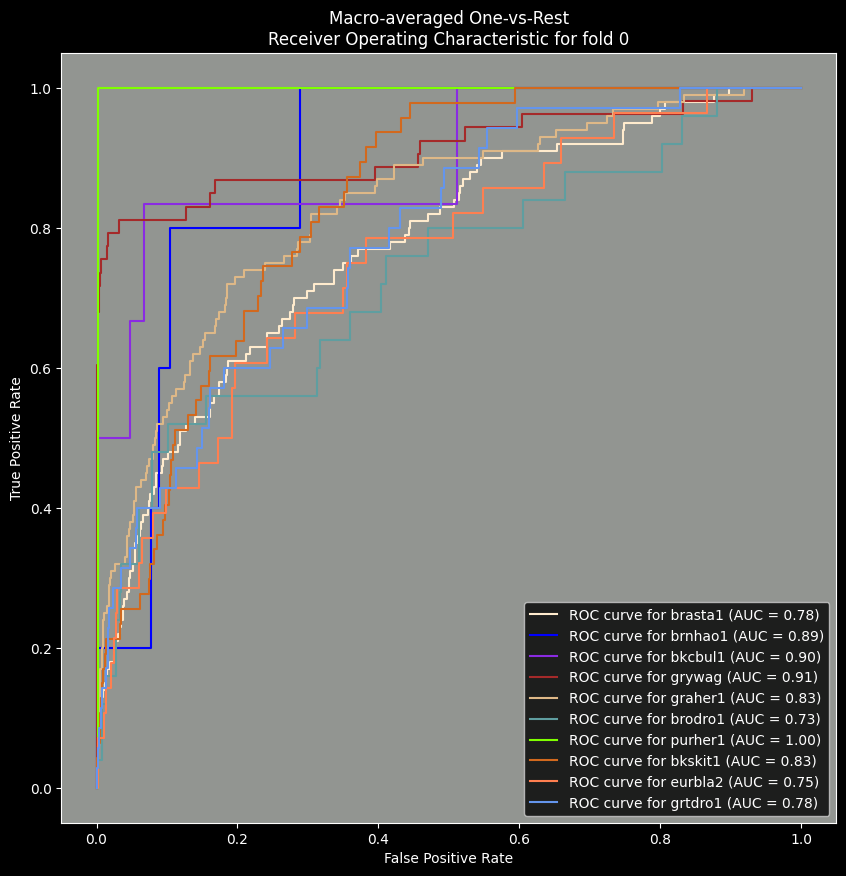

In [25]:
#from itertools import cycle

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('xkcd:grey')
bird_list = annotated_data['label'].unique().tolist()
#colors = cycle(bird_list)

for class_id, color in zip(range(10,20), colors[8:18]):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {bird_list[class_id]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Macro-averaged One-vs-Rest\nReceiver Operating Characteristic for fold 0",
)

In [ ]:
ros = RandomOverSampler(random_state=42)
features_resampled, labels_resampled = ros.fit_resample(x, y)

print(features_resampled.shape)
print(labels_resampled.shape)

In [ ]:
unique_labels = labels_resampled.unique().sort()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model = random_forest_classifier.fit(x_train, y_train)
y_predict = random_forest_model.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

In [ ]:
y_predict_proba = random_forest_model.predict_proba(x_test)

In [ ]:
roc_score = roc_auc_score(y_test, y_predict_proba, multi_class='ovo', average='macro', labels=unique_labels)
print("ROC AUC Score:", roc_score)

In [ ]:
def evaluate_model(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')
    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(y_test, y_predict)
# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
dump(random_forest_model, 'audio_classifier_model.joblib')

In [ ]:
def audio_classification(file_path):
    audio = file_path
    print(audio)
    extracted_features = extract_features(audio).reshape(1, -1)
    y_predict = random_forest_model.predict(extracted_features)
    labels_list = annotated_data['label'].unique()
    encoded_label = annotated_data['encoded_label'].unique()

    labels = {}
    for label, prediction in zip(encoded_label, labels_list):
        labels[label] = prediction
    if y_predict[0] in labels.keys():
        predicted = ('Predicted Class:', labels[y_predict[0]])
    return predicted

In [ ]:
extracted_features = extract_features('/kaggle/input/birdclef-2024/unlabeled_soundscapes/1002849488.ogg').reshape(1, -1)
y_predict_proba = random_forest_model.predict_proba(extracted_features)
y_predict = random_forest_model.predict(extracted_features)

In [ ]:
labels_list = annotated_data['label'].unique()
encoded_label = annotated_data['encoded_label'].unique()

In [ ]:
labels = {}
for label, prediction in zip(encoded_label, labels_list):
    labels[label] = prediction
    
labels.keys()

In [ ]:
labels[y_predict[0]]

In [ ]:
file_path = '/kaggle/input/birdclef-2024/unlabeled_soundscapes/1002849488.ogg'
audio_analysis(file_path)
Audio(file_path)

In [ ]:
audio_classification(file_path)

In [ ]:
sample_submission = pl.read_csv('/kaggle/input/birdclef-2024/sample_submission.csv', low_memory=True)
print(sample_submission.shape)
sample_submission.head(10)

In [ ]:
sample_submission2 = sample_submission.drop("row_id")
sample_submission2.sum_horizontal()

In [ ]:
print(np.array(sample_submission2)[2].shape)
print(np.array(sample_submission2).shape)

In [ ]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True, as_frame=False)
print(X.shape)
print(type(y))
print(X.shape)
print(y.shape)
print(X[2])
print(y[2])
print(y[[10, 25, 50]])

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver="liblinear").fit(X, y)
print(clf.predict_proba(X).shape)
print(clf.predict_proba(X)[4].shape)

In [ ]:
sample_labels = [i for i in range(0, 182, 1)]
len(sample_labels)

In [ ]:
y_true_sample = np.array([0,1,2])
roc_auc_score(y_true_sample, sample_submission2, multi_class='ovo', average='macro', labels=sample_labels)

In [ ]:
roc_auc_score(y_true_sample, sample_submission2, multi_class='ovr', average='micro', labels=sample_labels)